# Расчет вероятности оттока клиентов


А. Н. Зацепин

Аннотация: в материале продемонстрировано использование алгоритма машинного обучения "Случайный лес" (Random forest) в задаче прогнозирования оттока клиентов. Реализация моделирования выполнена на языке программирования Python с использованием библиотек scikit-learn, pandas, numpy.

#### Подготовка: импорт необходимых библиотек и методов, загрузка исходных данных из файла churn_utf.txt с помощью метода read_csv библиотеки pandas. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as Rf
from sklearn.metrics import confusion_matrix
from matplotlib.pylab import rc, plot

churn_df = pd.read_csv('churn_utf.txt') #Загружаем исходную таблицу из файла churn_utf.txt, 
                                        #создаем структуру pandas DataFrame 

#### Анализ исходных данных.

Отображаем первые 5 строк загруженной таблицы, анализируем корректность загрузки.

In [2]:
pd.set_option('display.max_columns', 100) # Устанавливаем опцию отображения, чтобы не скрывать столбцы при выводе 
display(churn_df.head())

,Штат,Длина счета,Код зоны,Номер телефона,Услуга международных звонков,Услуга VMail,Количество VMail,Дневные минуты,Дневные звонки,Дневная оплата,Вечерние минуты,Вечерние звонки,Вечерняя оплата,Ночные минуты,Ночные звонки,Ночная оплата,Международные минуты,Международные звонки,Международная оплата,Обращений в СЦ,Уход
0,KS,128,415,382-4657,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Выводим размерность загруженной таблицы

In [3]:
churn_df.shape

(3333, 21)

Выводим список заголовков столбцов загруженной таблицы.

In [4]:
churn_df.columns

Index(['Штат', 'Длина счета', 'Код зоны', 'Номер телефона',
       'Услуга международных звонков', 'Услуга VMail', 'Количество VMail',
       'Дневные минуты', 'Дневные звонки', 'Дневная оплата', 'Вечерние минуты',
       'Вечерние звонки', 'Вечерняя оплата', 'Ночные минуты', 'Ночные звонки',
       'Ночная оплата', 'Международные минуты', 'Международные звонки',
       'Международная оплата', 'Обращений в СЦ', 'Уход'],
      dtype='object')

Выводим общую информацию по загруженной таблице (датафрейму). При загрузке данных типы установлены корректно, дополнительные преобразования не требуются.

In [5]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Штат                          3333 non-null   object 
 1   Длина счета                   3333 non-null   int64  
 2   Код зоны                      3333 non-null   int64  
 3   Номер телефона                3333 non-null   object 
 4   Услуга международных звонков  3333 non-null   bool   
 5   Услуга VMail                  3333 non-null   bool   
 6   Количество VMail              3333 non-null   int64  
 7   Дневные минуты                3333 non-null   float64
 8   Дневные звонки                3333 non-null   int64  
 9   Дневная оплата                3333 non-null   float64
 10  Вечерние минуты               3333 non-null   float64
 11  Вечерние звонки               3333 non-null   int64  
 12  Вечерняя оплата               3333 non-null   float64
 13  Ноч

#### Предварительная обработка данных

Разделяем исходную таблицу на две части: первая будет использована для обучения и тестирования модели, вторая имитирует дальнейшую работу с моделью пользователей: предполагается, что при последующей работе пользователи готовят данные в исходном формате о новых пользователях, для которых потребуется рассчитать вероятность ухода.

Разделение выполняется с помощью метода train_test_split, позволяющего выполнить перемешивание при разделении с целью имитации разнообразия данных в тестовой выборке.  

In [6]:
churn_df_work, churn_df_input = train_test_split(churn_df, train_size=0.99, random_state=42)

# Сохраняем выделенный набор данных для дальнейшей работы, отбросив графу "Уход"
churn_df_input.drop('Уход', axis=1).to_csv('test_input.csv', sep=";", index=False) 

print("Размерность выборки для дальнейшей обработки:", churn_df_work.shape)
print("Размерность выборки для дальнейшего тестирования:", churn_df_input.shape)

Размерность выборки для дальнейшей обработки: (3299, 21)
Размерность выборки для дальнейшего тестирования: (34, 21)


Выделяем колонку, в которой содержатся данные об уходе клиентов. Эти данные являются целевыми для моделирования. Выполняем преобразование булевого типа в целочисленный - это необходимо для дальнейшего обучения модели.

In [7]:
churn_result = churn_df_work['Уход']
y = np.where(churn_result, 1, 0)

print(y[:30]) # Вывести первые 30 значений для контроля

[0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]


Удаляем колонки, которые не требуются для дальнейшей работы

In [8]:
to_drop = ['Штат', 'Код зоны', 'Номер телефона', 'Уход']
churn_feat_space = churn_df_work.drop(to_drop, axis=1)

Подготавливаем входные данные для обучения модели. Выполняем преобразование всех данных к типу с плавающей точкой (необходимо для дальнейшей обработки). Выполняем нормализацию данных с помощью метода StandardScaler, приводя значение каждого признака к диапазону от 1,0 до -1,0. Это требуется для обеспечения равного веса всех признаков при обучении модели.

In [9]:
X = churn_feat_space.values.astype(float)

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"Набор признаков содержит {X.shape[0]} значений для {X.shape[1]} признаков.")
print("Уникальные целевые значения:", np.unique(y))

Набор признаков содержит 3299 значений для 17 признаков.
Уникальные целевые значения: [0 1]


#### Обучение модели

Библиотека scikit-learn позволяет использовать различные методы машинного обучения. В данной работе используется Random forest ( «случайный лес») — алгоритм машинного обучения, предложенный Лео Брейманом и Адель Катлер, заключающийся в использовании комитета (ансамбля) решающих деревьев. Алгоритм сочетает в себе две основные идеи: метод бэггинга Бреймана, и метод случайных подпространств, предложенный Тин Кам Хо. Алгоритм применяется для задач классификации, регрессии и кластеризации. Основная идея заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается хорошим.

Алгоритм Random forest выбран, поскольку ряд исследований показали его преимущество для решения поставленной задачи.

Выполняем разбиение подготовленных данных на обучающую и тестовую части, при этом производим стратификацию (равномерное распределение) классов данных с помощью. Далее выполняем обучение модели.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.3, random_state=42)
print("Размерность выборки для обучения модели:", X_train.shape)
print("Размерность выборки для тестирования:", X_test.shape)

rf = Rf(n_estimators=10) # Создаем объект класса RandomForestClassifier
rf.fit(X_train, y_train) # Выполняем процедуру обучения

Размерность выборки для обучения модели: (2309, 17)
Размерность выборки для тестирования: (990, 17)


RandomForestClassifier(n_estimators=10)

#### Исследование точности моделирования

Строим матрицу ошибок.

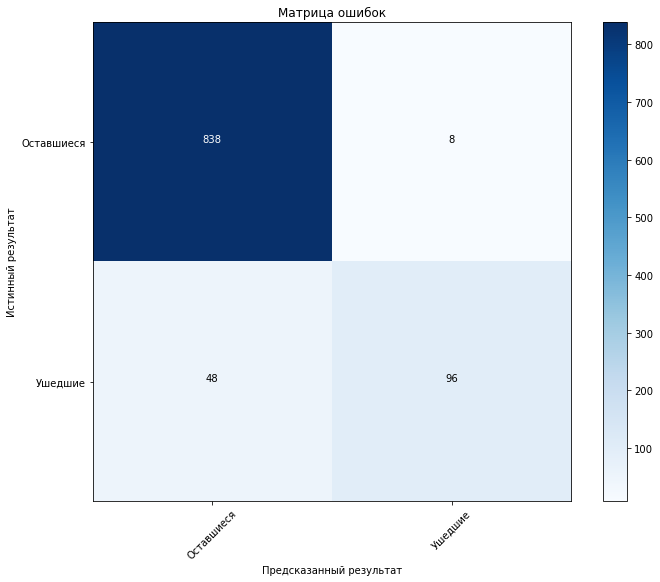

In [11]:
cnf_matrix = confusion_matrix(y_test, rf.predict(X_test))

plt.figure(figsize=(10, 8))
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Матрица ошибок')
plt.colorbar()
classes = ['Оставшиеся', 'Ушедшие']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Истинный результат')
plt.xlabel('Предсказанный результат')    
font = {'size' : 15}
plt.rc('font', **font)
plt.savefig("conf_matrix.png")
plt.show()

Оценка по метрике "Точность классификации".

In [12]:
accuracy = (cnf_matrix[0,0] + cnf_matrix[1,1])/cnf_matrix.sum()
print(f"accuracy = {accuracy:.2}")

accuracy = 0.94


Оценка по метрике "Точность".

In [13]:
precision = cnf_matrix[0,0] / (cnf_matrix[0,0] + cnf_matrix[1,0])
print(f"precision = {precision:.2}")

precision = 0.95


Оценка по метрике "Полнота".

In [14]:
recall = cnf_matrix[0,0] / (cnf_matrix[0,0] + cnf_matrix[0,1])
print(f"recall = {recall:.2}")

recall = 0.99


Выполним оценку предсказания вероятности ухода клиента. Выделим 10 уровней вероятности от 0 до 1.

In [15]:
pred_prob = rf.predict_proba(X)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn).sort_index()

# calculate true probabilities
true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts = pd.concat([counts,counts['index'] - counts[1]], axis=1)
counts.columns = ['pred_prob', 'count', 'true_prob', 'delta']
print(counts)

    pred_prob  count  true_prob     delta
0         0.0   2073   0.006753 -0.006753
1         0.1    517   0.005803  0.094197
2         0.2    160   0.025000  0.175000
3         0.3     66   0.045455  0.254545
4         0.4     24   0.541667 -0.141667
5         0.5     34   0.794118 -0.294118
6         0.6     42   0.904762 -0.304762
7         0.7     67   0.940299 -0.240299
8         0.8     78   0.987179 -0.187179
9         0.9    111   1.000000 -0.100000
10        1.0    127   1.000000  0.000000


#### Имитация работы модели с запросами пользователей

После обучения мы получили модель, позволяющую предсказывать вероятность оттока конкретных клиентов. Дальнейшее использование может происходить по следующей схеме: пользователь готовит набор исходных данных в файле CSV со структурой, аналогичной использованной ранее (за исключением графы "Уход", поскольку прогноз составляется в отношении действующих клиентов).
Ранее часть исходного набора данных была сохранена в файл test_input.csv для имитации запроса пользователя системы. Выполним загрузку этих данных.

In [16]:
churn_df_user = pd.read_csv('test_input.csv', sep=";")
churn_df_user.head()

,Штат,Длина счета,Код зоны,Номер телефона,Услуга международных звонков,Услуга VMail,Количество VMail,Дневные минуты,Дневные звонки,Дневная оплата,Вечерние минуты,Вечерние звонки,Вечерняя оплата,Ночные минуты,Ночные звонки,Ночная оплата,Международные минуты,Международные звонки,Международная оплата,Обращений в СЦ
0,WY,113,510,352-6573,False,False,0,155.0,93,26.35,330.6,106,28.10,189.4,123,8.52,13.5,3,3.65,1
1,IL,67,415,369-4377,False,False,0,109.1,117,18.55,217.4,124,18.48,188.4,141,8.48,12.8,6,3.46,0
2,SD,98,415,392-2555,False,False,0,0.0,0,0.00,159.6,130,13.57,167.1,88,7.52,6.8,1,1.84,4
3,KY,147,408,396-2945,False,False,0,212.8,79,36.18,204.1,91,17.35,156.2,113,7.03,10.2,2,2.75,1
4,WY,96,408,329-2045,False,False,0,144.0,102,24.48,224.7,73,19.10,227.7,91,10.25,10.0,7,2.70,1


Предобработка данных.

In [17]:
to_drop = ['Штат', 'Код зоны', 'Номер телефона']
X = scaler.fit_transform(churn_df_user.drop(to_drop, axis=1).values.astype(float))

Готовим результаты обработки. В выходном файле содержатся данные о клиенте (Штат, Длина счета, Код зоны, Номер телефона), показатель «ценность клиента» - сумма всех платежей, взимаемых с данного клиента. В результате комбинации этой величины с вероятностью ухода клиента получается очень важный показатель: ожидаемая утраченная прибыль в случае ухода данного клиента. 

In [18]:
pred_user_prob = rf.predict_proba(X)[:,1]
response = churn_df_user[['Штат','Длина счета', 'Код зоны', 'Номер телефона']]
charges = ['Дневная оплата','Вечерняя оплата','Ночная оплата','Международная оплата']
response.insert(4,'Ценность клиента', round(churn_df_user[charges].sum(axis=1), 2))
response.insert(5,'Вероятность ухода', pred_user_prob)
response

,Штат,Длина счета,Код зоны,Номер телефона,Ценность клиента,Вероятность ухода
0,WY,113,510,352-6573,66.62,0.3
1,IL,67,415,369-4377,48.97,0.0
2,SD,98,415,392-2555,22.93,1.0
3,KY,147,408,396-2945,63.31,0.1
4,WY,96,408,329-2045,56.53,0.0
5,DC,119,408,418-7478,49.46,0.2
6,AR,116,510,409-5519,54.96,0.1
7,WY,114,415,403-7775,50.33,0.0
8,MS,130,510,347-3895,60.19,0.1
9,WY,78,415,399-6259,52.91,0.0


Сохраняем результаты отсортированные по вероятности ухода в файл test_output.csv.

In [19]:
response.sort_values('Вероятность ухода', ascending=False).to_csv('test_output.csv', sep=";", index=False)